# <center> CS4641 Project Unsupervised Learning </center>

In [66]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sqlite3
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

con = sqlite3.connect("/content/gdrive/My Drive/Colab Notebooks/wildfires.sqlite")

Let's select all relevant features from this database.

In [68]:
CATEGORICAL = ["NWCG_REPORTING_AGENCY", "FIRE_SIZE_CLASS", "STATE"]
NUMERICAL = ["FIRE_YEAR", "DISCOVERY_DOY", "DISCOVERY_DATE", "STAT_CAUSE_CODE", "CONT_DOY", "CONT_DATE", "FIRE_SIZE", "LATITUDE", "LONGITUDE", "OWNER_CODE"]
fires_table = pd.read_sql_query("SELECT * from Fires", con)
wildfires = fires_table[NUMERICAL + CATEGORICAL]

In [69]:
wildfires.head()

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_DATE,STAT_CAUSE_CODE,CONT_DOY,CONT_DATE,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,NWCG_REPORTING_AGENCY,FIRE_SIZE_CLASS,STATE
0,2005,33,2453403.5,9.0,33.0,2453403.5,0.10,40.036944,-121.005833,5.0,FS,A,CA
1,2004,133,2453137.5,1.0,133.0,2453137.5,0.25,38.933056,-120.404444,5.0,FS,A,CA
2,2004,152,2453156.5,5.0,152.0,2453156.5,0.10,38.984167,-120.735556,13.0,FS,A,CA
3,2004,180,2453184.5,1.0,185.0,2453189.5,0.10,38.559167,-119.913333,5.0,FS,A,CA
4,2004,180,2453184.5,1.0,185.0,2453189.5,0.10,38.559167,-119.933056,5.0,FS,A,CA


Next, we will create a basic correlation matrix for our features.

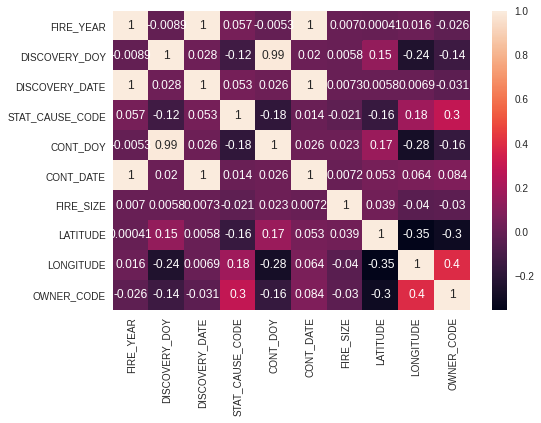

In [70]:
corr_matrix = wildfires.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

From this matrix, we see that there is some correlation between owner code and the stat_cause_code (0.3), cont_day and discovery_doy (0.99), and between longitude and stat_cause_code (0.18).

Let's take a closer look at owner code and the stat_cause_code.

In [71]:
owners = fires_table.groupby(["OWNER_CODE", "OWNER_DESCR"])
owners.size()

OWNER_CODE  OWNER_DESCR          
0.0         FOREIGN                       15
1.0         BLM                        63278
2.0         BIA                       106819
3.0         NPS                        17524
4.0         FWS                        12191
5.0         USFS                      188338
6.0         OTHER FEDERAL               6452
7.0         STATE                      30790
8.0         PRIVATE                   314822
9.0         TRIBAL                      8952
10.0        BOR                          285
11.0        COUNTY                      1841
12.0        MUNICIPAL/LOCAL             4236
13.0        STATE OR PRIVATE           71881
14.0        MISSING/NOT SPECIFIED    1050835
15.0        UNDEFINED FEDERAL           2206
dtype: int64

In [72]:
owners.size().sort_values(ascending=False)

OWNER_CODE  OWNER_DESCR          
14.0        MISSING/NOT SPECIFIED    1050835
8.0         PRIVATE                   314822
5.0         USFS                      188338
2.0         BIA                       106819
13.0        STATE OR PRIVATE           71881
1.0         BLM                        63278
7.0         STATE                      30790
3.0         NPS                        17524
4.0         FWS                        12191
9.0         TRIBAL                      8952
6.0         OTHER FEDERAL               6452
12.0        MUNICIPAL/LOCAL             4236
15.0        UNDEFINED FEDERAL           2206
11.0        COUNTY                      1841
10.0        BOR                          285
0.0         FOREIGN                       15
dtype: int64

In [73]:
causes = fires_table.groupby(["STAT_CAUSE_CODE", "STAT_CAUSE_DESCR"])
causes.size()

STAT_CAUSE_CODE  STAT_CAUSE_DESCR 
1.0              Lightning            278468
2.0              Equipment Use        147612
3.0              Smoking               52869
4.0              Campfire              76139
5.0              Debris Burning       429028
6.0              Railroad              33455
7.0              Arson                281455
8.0              Children              61167
9.0              Miscellaneous        323805
10.0             Fireworks             11500
11.0             Powerline             14448
12.0             Structure              3796
13.0             Missing/Undefined    166723
dtype: int64

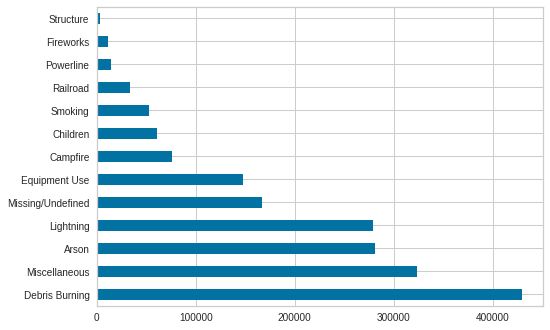

In [74]:
fires_table['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh')
plt.show()

In [75]:
combined = fires_table.groupby(["OWNER_CODE", "STAT_CAUSE_CODE"])
combined.size()

OWNER_CODE  STAT_CAUSE_CODE
0.0         5.0                    4
            7.0                    1
            9.0                    4
            13.0                   6
1.0         1.0                44175
                               ...  
15.0        9.0                  464
            10.0                  21
            11.0                  21
            12.0                   6
            13.0                 203
Length: 197, dtype: int64

In [76]:
# Cleveland dot plot for this data?
res = combined.size() / combined.size().groupby(level=0).sum()
res

OWNER_CODE  STAT_CAUSE_CODE
0.0         5.0                0.266667
            7.0                0.066667
            9.0                0.266667
            13.0               0.400000
1.0         1.0                0.698110
                                 ...   
15.0        9.0                0.210335
            10.0               0.009519
            11.0               0.009519
            12.0               0.002720
            13.0               0.092022
Length: 197, dtype: float64

In [77]:
# res.loc[res["OWNER_CODE"] == 0.0]
# combined.groups

In [78]:
clustering_features = ["OWNER_CODE", "STAT_CAUSE_CODE", "STATE"]
clustering_data = fires_table[clustering_features]
clustering_data.head()

,OWNER_CODE,STAT_CAUSE_CODE,STATE
0,5.0,9.0,CA
1,5.0,1.0,CA
2,13.0,5.0,CA
3,5.0,1.0,CA
4,5.0,1.0,CA


In [79]:
le = preprocessing.LabelEncoder()
le.fit(clustering_data["STATE"].unique())
clustering_data.loc[:, "STATE"] = le.transform(clustering_data["STATE"])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [80]:
# mms = preprocessing.MinMaxScaler()
# mms.fit(clustering_data)
# data_transformed = mms.transform(clustering_data)
# Sum_of_squared_distances = []
# K = range(1,15)
# for k in K:
#     km = KMeans(n_clusters=k)
#     km = km.fit(data_transformed)
#     Sum_of_squared_distances.append(km.inertia_)
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [81]:
# kmeans = KMeans(n_clusters=7, random_state=0).fit(clustering_data)
# kmeans.cluster_centers_

# New Results

Let's determine if statistical causes vary by location. For example, let's compare California and Georgia.

In [82]:
features = ["STATE", "STAT_CAUSE_DESCR"]
data = fires_table[features]
ca = data.loc[data["STATE"] == "CA"]
ca_causes = ca["STAT_CAUSE_DESCR"].value_counts(normalize=True)
ga = data.loc[data["STATE"] == "GA"]
ga_causes = ga["STAT_CAUSE_DESCR"].value_counts(normalize=True)

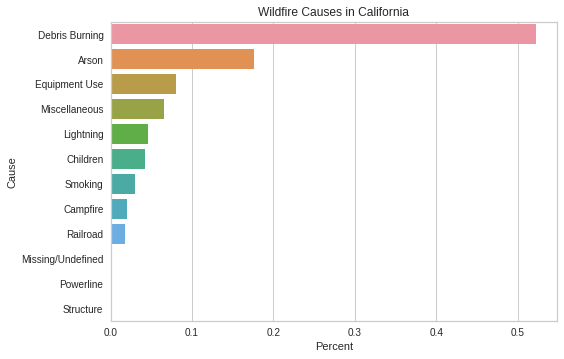

In [83]:
ax = sn.barplot(x=ga_causes.values, y=ga_causes.index)
plt.title("Wildfire Causes in California")
plt.xlabel("Percent")
plt.ylabel("Cause")
plt.show()

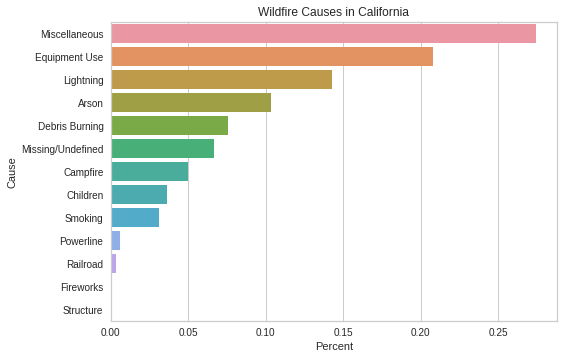

In [84]:
ax = sn.barplot(x=ca_causes.values, y=ca_causes.index)
plt.title("Wildfire Causes in California")
plt.xlabel("Percent")
plt.ylabel("Cause")
plt.show()

We see large variance in the types of causes present at each state. We will look more closely at lightning, and find that it is indicative of a greater trend. Lightning-caused fires are more prevalent along the West Coast.

In [85]:
features = ["LATITUDE", "LONGITUDE", "STAT_CAUSE_DESCR"]
clustering_data = fires_table[features]
clustering_data.head()

,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR
0,40.036944,-121.005833,Miscellaneous
1,38.933056,-120.404444,Lightning
2,38.984167,-120.735556,Debris Burning
3,38.559167,-119.913333,Lightning
4,38.559167,-119.933056,Lightning


In [86]:
lightning_data = clustering_data.loc[clustering_data["STAT_CAUSE_DESCR"] == "Lightning"]
del lightning_data["STAT_CAUSE_DESCR"]
lightning_data.head()

,LATITUDE,LONGITUDE
1,38.933056,-120.404444
3,38.559167,-119.913333
4,38.559167,-119.933056
5,38.635278,-120.103611
6,38.688333,-120.153333


In [87]:
lightning_data = np.radians(lightning_data)
test = lightning_data.sample(frac=0.0005)
test.size

278

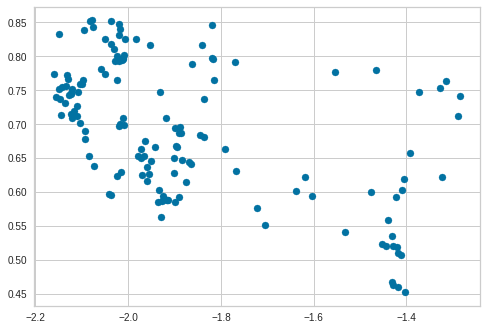

In [88]:
plt.scatter(test.iloc[:,1], test.iloc[:,0])

In [89]:
from sklearn.cluster import DBSCAN, OPTICS

model = OPTICS(metric="haversine", algorithm="ball_tree")
# model = DBSCAN(eps=0.0000001, min_samples=5, algorithm='ball_tree', metric='haversine')
model.fit(test)
labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [90]:
n_clusters_

10

Text(0.5, 1.0, 'DBSCAN')

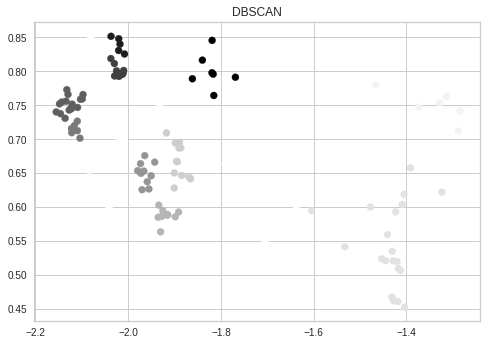

In [91]:
plt.scatter(test.iloc[:,1], test.iloc[:,0], c=labels); 
plt.title("DBSCAN")

In other words, lightning is more common along the West Coast than the East. Other causes also differ in their prevalence in various locations. Therefore, when we perform supervised learning, it might be possible to infer location from the cause. Next, we will consider any correlation between fire size and containment time.

In [92]:
features = ["FIRE_SIZE_CLASS", "DISCOVERY_DATE", "CONT_DATE", "FIRE_SIZE"]
clustering_data = fires_table[features]
clustering_data.head()

,FIRE_SIZE_CLASS,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE
0,A,2453403.5,2453403.5,0.10
1,A,2453137.5,2453137.5,0.25
2,A,2453156.5,2453156.5,0.10
3,A,2453184.5,2453189.5,0.10
4,A,2453184.5,2453189.5,0.10


In [93]:
data = clustering_data.loc[~clustering_data["FIRE_SIZE_CLASS"].isin(["A", "B"])]
data.size

1096680

In [94]:
data["TIME_TO_CONT"] = data["CONT_DATE"] - data["DISCOVERY_DATE"]
data = data.loc[~data["TIME_TO_CONT"].isin([0.0, "nan"])]
# data = data.loc[data["TIME_TO_CONT"] != 0.0]
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,FIRE_SIZE_CLASS,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,TIME_TO_CONT
16,G,2453284.5,2453299.5,16823.0,15.0
17,G,2453291.5,2453295.5,7700.0,4.0
37,C,2453397.5,2453398.5,50.3,1.0
39,D,2453413.5,2453414.5,125.0,1.0
85,C,2453558.5,2453559.5,45.6,1.0


In [95]:
largest_fire = data.iloc[data["FIRE_SIZE"].argmax()]
print(largest_fire["DISCOVERY_DATE"], largest_fire["CONT_DATE"], largest_fire["TIME_TO_CONT"])

2450624.5 2450700.5 76.0


In [96]:
smallest_fire = data.iloc[data["FIRE_SIZE"].argmin()]
print(smallest_fire["DISCOVERY_DATE"], smallest_fire["CONT_DATE"], smallest_fire["TIME_TO_CONT"])

2453549.5 2453550.5 1.0


In [97]:
data = data.loc[data["TIME_TO_CONT"] <= 600]
data.size

235135

In [98]:
del data["FIRE_SIZE_CLASS"]
del data["DISCOVERY_DATE"]
del data["CONT_DATE"]

In [99]:
data.head()

,FIRE_SIZE,TIME_TO_CONT
16,16823.0,15.0
17,7700.0,4.0
37,50.3,1.0
39,125.0,1.0
85,45.6,1.0


array([9, 7, 1, ..., 1, 1, 1], dtype=int32)

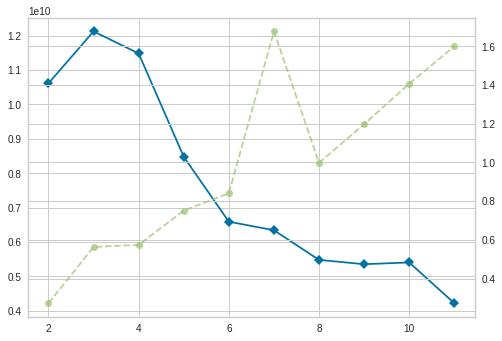

In [100]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

viz = KElbowVisualizer(KMeans(), k=(2,12), locate_elbow=True)
viz.fit(data)
# viz.show() <-- Not working for some reason... maybe try on a different notebook
viz.labels_

In [101]:
model = KMeans(n_clusters=6)
model.fit(data)
model.labels_

array([4, 0, 0, ..., 0, 0, 0], dtype=int32)

Text(0, 0.5, 'Time to Contain (days)')

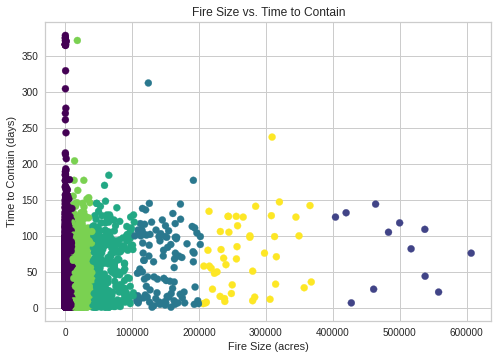

In [102]:
plt.scatter(data["FIRE_SIZE"], data["TIME_TO_CONT"], c=model.labels_, cmap="viridis"); 
plt.title("Fire Size vs. Time to Contain")
plt.xlabel("Fire Size (acres)")
plt.ylabel("Time to Contain (days)")

Surprisingly, there was no clear relation between a fire's size and the time required to contain it. Perhaps this is due to errors/bias in the data entry.